In [36]:
import os
import sys
sys.path.append('../')

from helpers import helper
from dataloaders import dataloader
from networks import Unet
import config

import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = config.get_device()
trainset, train_dl = dataloader.getData('../../datasets/train.csv', batch_size=4)


Using device: mps


Load model from ../models/unet_default.pth
Input shape: torch.Size([4, 3, 256, 256])
Output shape torch.Size([4, 2, 256, 256])
loss: 1395.218505859375


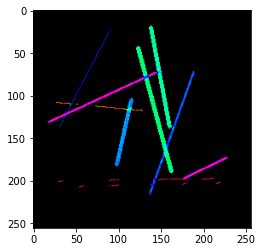

In [37]:
network, network_dir = Unet.get_model(), "Unet"
def test(decoder, train_dl):
    decoder.to(device)
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        print("Input shape:", images.shape)
        outputs = decoder(images)

        helper.plot_tensor_output(outputs[0])

        print("Output shape", outputs.shape)
        break

    loss = nn.MSELoss(reduction='sum')(outputs, labels)
    loss.backward()
    print(f'loss: {loss.item()}')
    
test(network, train_dl)

In [20]:
def train_one_epoch(network, train_dl, criterion, optimizer, scaler, device):
    # train_acc = 0.0
    train_loss = 0.0
    network.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = network(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # acc = ((output.argmax(dim=1) == labels).float().mean())
        # train_acc += acc
        train_loss += loss
        del output
        del loss
        
    # Decay LR by a factor of 0.1 every 2 epochs
    # exp_lr_scheduler.step()
    network.save()
    return train_loss/len(train_dl)

def train(network, train_dl, device, epochs, lr=0.001):
    network.to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(network.parameters(), lr)
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(50):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        train_loss = train_one_epoch(network, train_dl, criterion, optimizer, scaler, device)
        print('Train Loss: {:.4f}'.format(train_loss))
        network.save()

train(network, train_dl, device, 50, lr=0.001)

/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Epoch 1/50


  0%|          | 0/2500 [00:00<?, ?it/s]/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 2500/2500 [40:43<00:00,  1.02it/s]     


Train Loss: 1427.5366
Epoch 2/50


  2%|▏         | 52/2500 [00:27<21:30,  1.90it/s]


KeyboardInterrupt: 

In [35]:
# takes in a single image and outputs the predicted label
def validate(network, device, image_path, output_path=""):
    network.eval()
    network.to(device)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = config.transform(image).unsqueeze(0)
    output = network(image.to(device))
    if output_path != "":
        helper.save_tensor_output(output[0], output_path)

network, network_dir = Unet.get_model(), "Unet"
for direction in tqdm(range(0, 80, 1)):
    for thickness in range(1, 4):
        image_path = f'../../datasets/experiment/images/img_{direction}_{thickness}.png'
        output_path = f'../../datasets/experiment/outputs/{network_dir}/img_{direction}_{thickness}.png'
        # get the network and its output directory
        validate(network, device, image_path=image_path, output_path=output_path)


Load model from ../models/unet_default.pth


100%|██████████| 80/80 [00:20<00:00,  3.87it/s]


In [39]:
helper.convertDegreeToRadian(355)

3.0543261909900767